# Matching and Subclassification
----------------

Readings:

* **Cunningham, S. (2021)**. Causal Inference: The Mixtape. *Yale University Press, United States*.

* **Huntington-Klein, N. (2021)**. The Effect: An Introduction to Research Design and Causality. *Taylor & Francis Ltd, United Kingdom*.
-------------


In [1]:
# pip install plotnine
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

## Roadmap

* 1. Introduction
* 2. Subclassification
 * 2.1. Background
 * 2.2. Identifying Assumptions
 * 2.3. Example
 * 2.4. Course of dimensionality
* 3. Exact Matching
* 4. Approximate Matching
 * 4.1. Nearest neighbor covariate matching
 * 4.2. Bias Correction
* 5. Propensity score methods
 * 5.1. Example
 * 5.2.Weighting on the propensity score
 * 5.3. Nearest-neighbor matching
 * 5.4. Coarsened exact matching
* 6. Conclusion
    

## 1. Introduction

Matching is the process of closing back door paths between the treatment and outcome variable by constructing comparison groups that are similar in a one or more matching variables. In other words and assuming $W$ is the variable causing a back door path, then choosing a sample in which there is no variation in $W$ automatically closes any open back doors created by $W$.

Consider the following basic example: we are interested in estimating the effect of a job-training program on the probability of getting a job. The pool of people eligible for the program is about 50% male and 50% female, but the program was advertised strongly towards men, so the people who *actually* took part of the program were 80% men, 20% female. There is, therefore, a back door path created by the variable *gender*, so 
$Getting \: a \: Job	\leftarrow Gender \rightarrow Job \: Training \: Program$. 

The basic idea of the matching approach then is to construct a comparable control group that was also 80% men and 20% female. Comparing these treated and untreated groups, we eliminate the gender difference so $Gender \rightarrow JobTrainingProgram$ disappears and we can then identify $Job \: Training \: Program \rightarrow Getting \: a \:Job$ (assuming there are no other open back door paths). 

In what follows, we will discuss three different types of conditional strategies: subclassification, exact matching and appropiate matching. 

## 2. Subclassification

Subclassification is a method for closing back door paths by weighting difference in means by strata-specific weights. These strata-specific weights will, in turn, adjust the differences in means so that their distribution by strata is the same as that of the counterfactual’s strata. This method then achieves distributional *balance* between the treatment and control groups in terms of the observable confounder $W$. 

One of the key concepts for this chapter is the Conditional Independence Assumption (CIA):

$
(Y^1, Y^0) \perp D, X
$

which means that the expected values of $Y^1, Y^0$ are equal for both the treatment and control group for each value of $X$.

\begin{equation}
E[Y^1| D=1, X]= E[Y^1| D=0, X]
\end{equation}
\begin{equation}
E[Y^0| D=1, X]= E[Y^0| D=0, X]
\end{equation}

CIA means you have found a conditioning strategy that satisfies the backdoor criterion and $X$ can be a $nxk$ matrix of conditioning variables that satisfies the CIA assumption.

### 2.1. Background

From 1860 to 1950, the rate of lung cancer incidence appeared to be increasing and studies sugested that smoking was the **cause**. For example, studies found that the relationship between daily smoking and lung cancer in males was monotonically increasing in the number of cigarettes a male smoked per day. But maybe people who smoked were different from non-smokers in features that were related to the incidence of having or not lung cancer. If the independence assumption does not hold, then computing the difference in means from smokers and non-smokers will be biased.

For the following example, we follow Cochran (1968), a study trying to adress patterns in smoking data by adjusting for possible cofounders. The following table shows mortality rates by country and the type of smoking of individuals:


![title](Material/table1.png)

The table suggests that pipes and cigars are more dangerous than cigarette smoking (which does not make much sense). Recall the independence assumption and think whether it should hold:

$ E[Y^1|Cigarette]=E[Y^1|Pipe]=E[Y^1|Cigar]$

$ E[Y^0|Cigarette]=E[Y^0|Pipe]=E[Y^0|Cigar]$

If this holds, then it means that there is *balance* in covariates, which means that the covariates are the same for each group. Lets look into the mean ages of the different groups:

![title](Material/table2.png)

Here we see that cigar and pipe smokers are considerably older than cigar smokers for this particular dataset, which could be a reason why the death rates are higher among cigar and pipe smokers (since older people die at a higher rate for other reasons than smoking cigars). This could also be the reason why cigar smokers present a lower death rate, since they are on average younger.

Thus, we have a backdoor path that its open, and the CIA assumption is then violated. Also, the distribution of age for each group is different, leading to a covariate *imbalance*. A way to control for this is using subclassification. An example: 1) divide age into the following strata: 20-40; 41-70; 71 and older; 2) calculate the mortality rate for a treatment group (cigarette smokers) by strata; 3) weight the mortality rate for the treatment group by a strata-spefific weight that corresponds to the control group. With this procedure we achieve age-adjusted mortality rate for the treatment group.

![title](Material/table3.png)

Lets compute first the average death rate for pipe smokers without subclassification, where the weight is given by $\frac{N_t}{N}$:

$ 20 * \frac{75}{100} + 40 * \frac{25}{100} + 60 * \frac{10}{100}= 29$ 

With subclassification, we want to multiply each age-specific mortality rate by the proportion of individuals in that age strata for the comparision group:

$ 20 * \frac{10}{100} + 40 * \frac{25}{100} + 60 * \frac{65}{100}= 51$ 

Recalculating the mortality rates by adjusting for the age distribution, Cochran gets:

![title](Material/table4.png)

### 2.2. Identifying Assumptions

1. $(Y^1, Y^0) \perp D| X$ (conditional independence)

2. $ 0 < Pr(D=1|X) <1 $ (common support)

The two assumptions yield:

\begin{align*}
E[Y^1-Y^0| X] & = E[Y^1 - Y^0| X, D=1] \\
&=  E[Y^1| X, D=1] - E[Y^0| X, D=0] \\
&=  E[Y| X, D=1] - E[Y| X, D=0]
\end{align*}


And giving the common support assumption, we get:

$\hat{\delta_{ATE}}= \int (E[Y|X, D=1] - E[Y|X, D=0])d Pr(X)$

### 2.3. Exercise

We want to explore the question on whether or not being seated first class made someone more likely to survive. Being in first class is likely to explain the probability of survival; however, we encounter two backdoor paths: being a woman and being a child.

Here we will calculate a naïve simple difference in outcomes for the sample:

$E[Y|D=1]-E[Y|D=0]$

In [2]:
titanic = pd.read_stata("Data/titanic.dta")
titanic.head()

,class,age,sex,survived
0,1st class,adults,man,yes
1,1st class,adults,man,yes
2,1st class,adults,man,yes
3,1st class,adults,man,yes
4,1st class,adults,man,yes


We create a variable for treated group based on the survival status:

In [12]:
titanic['d'] = 0
titanic.loc[titanic['class']=='1st class', 'd'] = 1
titanic.head()

,class,age,sex,survived,d
0,1st class,adults,man,yes,1
1,1st class,adults,man,yes,1
2,1st class,adults,man,yes,1
3,1st class,adults,man,yes,1
4,1st class,adults,man,yes,1


In [3]:
titanic['d'] = np.where((titanic['class'] == '1st class'), 1, 0)
titanic['sex_d'] = np.where((titanic['sex'] == 'man'), 1, 0)
titanic['age_d'] = np.where((titanic['age'] == 'adults'), 1, 0)
titanic['survived_d'] = np.where((titanic['survived'] == 'yes'), 1, 0)
titanic.head()

,class,age,sex,survived,d,sex_d,age_d,survived_d
0,1st class,adults,man,yes,1,1,1,1
1,1st class,adults,man,yes,1,1,1,1
2,1st class,adults,man,yes,1,1,1,1
3,1st class,adults,man,yes,1,1,1,1
4,1st class,adults,man,yes,1,1,1,1


In [24]:
titanic.groupby('d')['survived_d'].mean()

d
0    0.270789
1    0.624615
Name: survived_d, dtype: float64

In [23]:
ey0 = titanic.loc[titanic['d']==0, 'survived_d'].mean()
ey0

0.27078891257995735

In [26]:
ey0 = titanic.loc[titanic['d']==0, 'survived_d'].mean()
ey1 = titanic.loc[titanic['d']==1, 'survived_d'].mean()

diff = ey1 - ey0
print("The naive difference in outcomes is {:.2%}".format(diff))

The naive difference in outcomes is 35.38%


Note that the later is a biased estimate of the ATE, so next we use subclassification weighting to control for cofounders.

*Steps*:

1. Stratify the data into four groups: young males, young females, old males, old females.
2. Calculate the difference in survival probabilities for each group.
3. Calculate the number of people in the non-first-class groups and divide by the total number of non-first-class population. These are our strata-specific weights.
4. Calculate the weighted average survival rate using the strata weights.

In [4]:
titanic['s'] = 0 
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==1), 's'] = 1 #woman and adult
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==0), 's'] = 2 #woman and child
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==1), 's'] = 3
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==0), 's'] = 4

In [13]:
obs=len(titanic.loc[titanic.d == 0])

In [15]:
def weighted_avg_effect(df):
    diff = df[df.d==1].survived_d.mean() - df[df.d==0].survived_d.mean()
    weight = len(df[df.d==0])/obs
    return diff*weight

In [16]:
wate = titanic.groupby('s').apply(weighted_avg_effect).sum()
print("The weigthted average treatment effect estimate is {:.2%}".format(wate))

The weigthted average treatment effect estimate is 18.88%


### 2.4. Course of dimensionality

What if the cofounder has multiple values? For example, what if instead of stratifying the data in adult or child (binary), we stratify for all age-values possible?

![title](Material/table5.png)

Here the common support assumption is being violated, since there are not any 12-year-old male passengers in first class, nor are there any 14-year-old male passengers in first class. Thus, we cannot estimate the ATE, since our stratifying variable has too many dimensions.

However, you could calculate the ATT if there is always someone in the control group for a given combination of gender and age, like 11-years-old and 13-years-old in the example above.

$\hat{\delta}_{ATT}= \sum_{k=1}^{K}(\bar{Y}^{1,k} - \bar{Y}^{0,k})  (\frac{N^{k}_{T}}{N_{T}})$

## 3. Exact Matching

What if we filled in the missing potential outcome for each treatment unit using a control group unit that was “closest” to the treatment group unit for some $X$ confounder? This approach is called matching and there exist exact and approximate matching.

A simple matching estimator is the following:

$\hat{\delta}_{ATT}= \frac{1}{{N_T}} \sum_{D_i=1} (Y_i- Y_{j(i)})$

where $Y_{j(i)}$ is the jth unit matched to the ith unit based on the idea that the jth unit is the closest to the ith unit given certain covariate. In the case where many units matches ith, we would assign the average outcome $\frac{1}{M}$ as the conterfactual.

$\hat{\delta}_{ATT}= \frac{1}{{N_T}} \sum_{D_i=1} (Y_i- [\frac{1}{M} \sum_{m=1}^{M}Y_{jm(1)}])$

We can estimate the ATE by filling both missing control group units.

$\hat{\delta}_{ATE}= \frac{1}{{N}} \sum_{i=1}^{N} (2D_i -1) (Y_i- [\frac{1}{M} \sum_{m=1}^{M}Y_{jm(1)}])$

In [21]:
training_data = pd.read_stata("Data/training_example.dta")
training_data.head()

,unit_treat,age_treat,earnings_treat,unit_control,age_control,earnings_control,unit_matched,age_matched,earnings_matched
0,1.0,18.0,9500,1.0,20.0,8500.0,1.0,18.0,8050.0
1,2.0,29.0,12250,2.0,27.0,10075.0,2.0,29.0,10525.0
2,3.0,24.0,11000,3.0,21.0,8725.0,3.0,24.0,9400.0
3,4.0,27.0,11750,4.0,39.0,12775.0,4.0,27.0,10075.0
4,5.0,33.0,13250,5.0,38.0,12550.0,5.0,33.0,11425.0


C:\Users\caroa\anaconda3\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_bin : Removed 14 rows containing non-finite values.


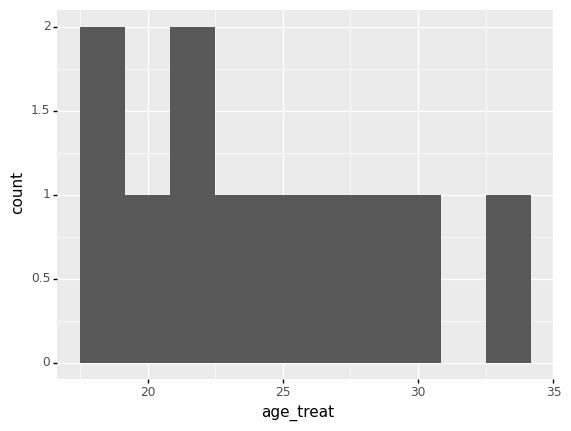

<ggplot: (147561751787)>

In [20]:
p.ggplot(training_data, p.aes(x='age_treat')) +  p.stat_bin(bins = 10)

C:\Users\caroa\anaconda3\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_bin : Removed 4 rows containing non-finite values.


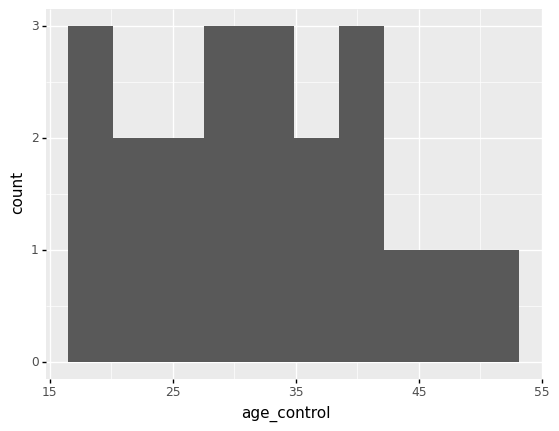

<ggplot: (147562355300)>

In [23]:
p.ggplot(training_data, p.aes(x='age_control')) +  p.geom_histogram(bins = 10)

*should we add this at all? or just leave as theory (equations)?

## 4. Approximate matching

### 4.1. Nearest neighbor covariate matching

When the number of matching covariates is more than one, we need a new definition of distance to measure closeness between units of observation. 

* **Euclidean distance**:

\begin{align*}
|| X_i - X_j|| & = \sqrt{(X_i - X_j)' (X_i-X_j)} \\
&=  \sqrt{\sum_{n=1}^{k}(X_{ni} - X_{nj})^2}
\end{align*}


* **Normalized Euclidean distance**, a commonly used distance, and what makes it different is that the distance of each variable is scaled by the variable’s variance:

$|| X_i - X_j|| = \sqrt{\sum_{n=1}^{k} \frac{(X_{ni} - X_{nj})}{\hat{\sigma_n}^2}}$

* **Mahalanobis distance**, another scale-invariant metric:

$|| X_i - X_j|| = \sqrt{(X_i - X_j)' \hat{\sum_{X}^{-1}} (X_i-X_j)}$

where $\hat{\sum_{X}^{-1}}$ is the variance-covariance matrix of $X$.

The problem with this is that we can introduce discrepancies; that is, when $X_i$ is not equal to $X_j$. Here, the difference is called bias, and it can be large, small or close to zero. For large samples, the bias tend to converge to zero. Hoewever, the larger the dimension, the greater likelihood of matching discrepancies, and the more data is needed.

### 4.2. Bias Correction

Bias derivation:

$\hat{\delta}_{ATT}= \frac{1}{N_T} \sum_{D_i=1}(Y_i-Y_{j(i)})$

$\mu^0(x)=E[Y|X=x, D=0]=E[Y^0|X=x]$

$\mu^1(x)=E[Y|X=x, D=1]=E[Y^1|X=x]$

where the observed value is a function of expected conditional outcomes and some stochastic element:

$Y_i=\mu^{D_i}(X_i) + \varepsilon_i$

rewriting the ATT estimator we get:

\begin{align*}
\hat{\delta}_{ATT} & =\frac{1}{N_T}\sum_{D_i=1}((\mu^{1}(X_i) + \varepsilon_i) - (\mu^{0}(X_{j(i)}) + \varepsilon_{j(i)})) \\
& =\frac{1}{N_T}\sum_{D_i=1}(\mu^{1}(X_i) - \mu^{0}(X_{j(i)}) + \frac{1}{N_T}\sum_{D_i=1} (\varepsilon_i - \varepsilon_{j(i)})
\end{align*}


Now lets compare the estimator with the true value of ATT:
\begin{align*}
\hat{\delta}_{ATT} - \delta_{ATT} & = \frac{1}{N_T}\sum_{D_i=1}(\mu^{1}(X_i) - \mu^{0}(X_{j(i)}) - \delta_{ATT} + \frac{1}{N_T}\sum_{D_i=1} (\varepsilon_i - \varepsilon_{j(i)}) \\
&=  \frac{1}{N_T}\sum_{D_i=1}(\mu^{1}(X_i) - \mu^{0}(X_{j(i)}) - \delta_{ATT}) + \frac{1}{N_T}\sum_{D_i=1} (\varepsilon_i - \varepsilon_{j(i)}) + \frac{1}{N_T}\sum_{D_i=1}(\mu^{0}(X_i) - \mu^{0}(X_{j(i)})
\end{align*}

$E[\sqrt{N_T}(\hat{\delta}_{ATT} - \delta_{ATT})]=E[\sqrt{N_T}(\mu^{0}(X_i) - \mu^{0}(X_{j(i)}| D=1]$

Consider when the number of covariates is large. Then:

* The difference between $X_i$ and $X_j(i)$ converges to zero slowly.

* $\mu^{0}(X_i) - \mu^{0}(X_{j(i)})$ converges slowly to zero.

* $E[\sqrt{N_T}(\mu^{0}(X_i) - \mu^{0}(X_{j(i)}| D=1]$ may not converge to zero.

* $E[\sqrt{N_T}(\hat{\delta}_{ATT}- \delta_{ATT})]$ may not converge to zero.

Note that the total bias is made up of the bias associated with each individual unit $i$. This means that each treated observation contributes $\mu^{0}(X_i) - \mu^{0}(X_{j(i)})$ to the overall bias. The bias corrected estimator following Abadie and Imbens (2011) is then:

$\frac{1}{N_T}\sum_{D_i=1}[(Y_i - Y_{j(i)}) - \hat{\mu}^{0}(X_i) - \hat{\mu}^{0}(X_{j(i)})]$

where one could use OLS to estimate $\hat{\mu}^{0}(X)$

Example:

In [28]:
training_bias_reduc = pd.read_stata("Data/training_bias_reduction.dta")
training_bias_reduc

,Unit,Y,D,X
0,1,5,1,11
1,2,2,1,7
2,3,10,1,5
3,4,6,1,3
4,5,4,0,10
5,6,0,0,8
6,7,5,0,4
7,8,1,0,1


In [32]:
training_bias_reduc['Y1'] = 0
training_bias_reduc.loc[training_bias_reduc['Unit'].isin(range(1,5)), 'Y1'] = 1
training_bias_reduc['Y0'] = (4,0,5,1,4,0,5,1)
training_bias_reduc

,Unit,Y,D,X,Y1,Y0
0,1,5,1,11,1,4
1,2,2,1,7,1,0
2,3,10,1,5,1,5
3,4,6,1,3,1,1
4,5,4,0,10,0,4
5,6,0,0,8,0,0
6,7,5,0,4,0,5
7,8,1,0,1,0,1


In [36]:
train_reg = sm.OLS.from_formula('Y ~ X', training_bias_reduc).fit()
training_bias_reduc['u_hat0'] = train_reg.predict(training_bias_reduc)
training_bias_reduc = training_bias_reduc[['Unit', 'Y1', 'Y0', 'Y', 'D', 'X', 'u_hat0']]
training_bias_reduc

,Unit,Y1,Y0,Y,D,X,u_hat0
0,1,1,4,5,1,11,3.888071
1,2,1,0,2,1,7,4.082474
2,3,1,5,10,1,5,4.179676
3,4,1,1,6,1,3,4.276878
4,5,0,4,4,0,10,3.936672
5,6,0,0,0,0,8,4.033873
6,7,0,5,5,0,4,4.228277
7,8,0,1,1,0,1,4.374080


### 5. Propensity score methods

The key idea behind propensity score methods is to compare units who, based on observables, had very similar probabilities of being placed into the treatment group even though those units differed with regard to actual treatment assignment. If conditional on any covariate, two units have the same probability of being treated, then one can say they have similar propensity scores, and all remaining variation in treatment assignment is random. Then, if also the CIA assumption credibly holds, then differences between their observed outcomes are attributable to the treatment.

#### 5.1. Example

The National Supported Work Demonstration (NSW) job-training program was a temporary employment program designed to help disadvantaged workers lacking basic job skills move into the labor market by giving them work experience and counseling in a sheltered environment.

The independence assumption in the NSW holds since it was randomized program, so calculating the treatment effect would be just a simple difference in means. Treatment group participants’ real earnings post-treatment in 1978 were more than earnings of the control group by approximately USD 900 (Lalonde 1986) to USD 1,800 (Dehejia and Wahba 2002), depending on the sample the researcher used.

Lalonde 1986 reviewed several econometric methods using data from the experimental control group and other sources of data for nonexperimental control groups (CPS and PSID) and compare them. The results show that there is a big difference between using the experimental control group and nonexperimental control groups for comparison. 

![title](Material/table6.png)

The reason is because of selection bias:

$E[Y^0|D=1] \neq E[Y^0|D=0]$

Also, the two groups (treatment and nonexperimental group) seem to be *not exchangeable* in covariates:

![title](Material/table7.png)

Lets now calculate the ATE using the NSW data:

In [5]:
nsw_dw = pd.read_stata('Data/nsw_mixtape.dta')
mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.35


Now, instead of calculating the ATE using the NSW data, lets use the CPS data, so now the control group consists of a random sample of Americans from that time period, whereas the treatment group belongs to an experimental group. Thus, the control group suffers from extreme selection bias since most Americans would not function as counterfactuals for the distressed group of workers who selected into the NSW program.

We can use propensity score matching as an improvement in estimating treatment effects using non-experimental data. Following Dehejia and Wahba (2002), we will append the CPS data to the experimental data and estimate the **propensity score** using logit. 

We use the estimated coefficients from the logit model to estimate the conditional probability of treatment:

$Pr(D=1|X)=F(\beta_0 + \gamma Treat + \alpha X)$

where $F()=\frac{e}{(1+e)}$

The definition of the propensity score is the selection probability conditional on the confounding variables

$p(X)=Pr(D=1|X)$

Recall our two assumptions: 1) CIA; 2) Common Support. The CIA assumption is not testable, but common support is testable by simply plotting histograms or summarizing the data.

In [6]:
nsw_dw_cpscontrol = pd.read_stata('Data/cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1

# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

treat
0.0    0.009212
1.0    0.190701
Name: pscore, dtype: float64

C:\Users\caroa\anaconda3\lib\site-packages\plotnine\facets\facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


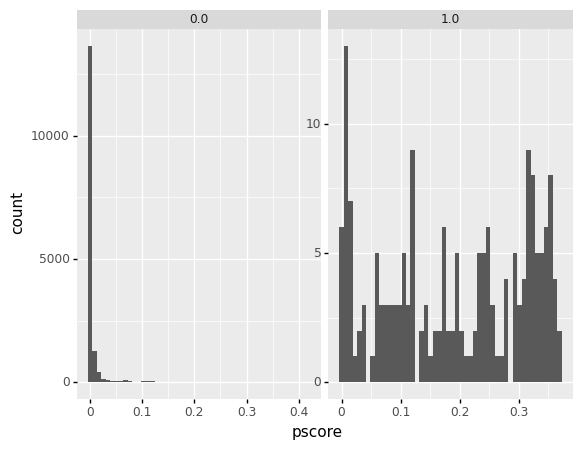

<ggplot: (147562639153)>

In [40]:
p.ggplot(nsw_dw_cpscontrol, p.aes(x='pscore')) +    p.geom_histogram(bins=50) +    p.facet_wrap("treat", scales='free')

In [49]:
df = (nsw_dw_cpscontrol.groupby('treat')['pscore']
        .quantile([.01,.05,.1,.25,.5,.75,.90,.95, .99]))
df

treat      
0.0    0.01    0.000040
       0.05    0.000046
       0.10    0.000053
       0.25    0.000091
       0.50    0.000380
       0.75    0.002481
       0.90    0.010569
       0.95    0.029357
       0.99    0.287441
1.0    0.01    0.001923
       0.05    0.005709
       0.10    0.011148
       0.25    0.086148
       0.50    0.195483
       0.75    0.313613
       0.90    0.343488
       0.95    0.354946
       0.99    0.364708
Name: pscore, dtype: float64

In [50]:
nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

treat
0.0    0.009212
1.0    0.190701
Name: pscore, dtype: float64

How to interpret the large mass of nearly zero propensity scores in the histogram?

The treatment parameter under the CIA and Common support assumption is:

\begin{align*}
E[\delta_i(X_i)] & =E=[Y_{i}^1 - Y_{i}^0| X_i=x] \\
&= E[Y_{i}^1|X_i=x]-E[Y_{i}^0|X_i=x]
\end{align*}

The CIA allows to:

$E[Y_{i}^1|D_i=1, X_i=x]= E[Y_{i}|D_i=1, X_i=x]$

so under both assumptions:

$\delta=E[\delta_i(X_i)]$

The *propensity score theorem* states that under the CIA this yields:

$(Y^1, Y^0) \perp D| p(X)$

where $p(X)$ is the propensity score.

**Proof of the propensity score**

\begin{align*}
Pr(D=1|Y^1, Y^0, p(X))& =E[D|Y^1, Y^0, p(X)] \\
&=\underbrace{E[E[D|Y^1, Y^0, p(X), X]|Y^1, Y^0, p(X)]}_{by \: LIE} \\
&=\underbrace{E[E[D|Y^1, Y^0, X]|Y^1, Y^0, p(X)]}_{given \: X \: we \: know \: p(X)} \\
&=\underbrace{E[E[D|X]|Y^1, Y^0, p(X)]}_{by \: conditional \: independence} \\
&=\underbrace{E[p(X)|Y^1, Y^0, p(X)]}_{propensity \: score \: definition} \\
&=p(X)
\end{align*}

proceeding similarly, we get:

\begin{align*}
Pr(D=1|p(X))& =\underbrace{E[D|p(X)]}_{previous \: argument} \\
&=\underbrace{E[E[D|X]|p(X)]}_{LIE} \\
&=\underbrace{E[p(X)|p(X)]}_{definition} \\
&=p(X)
\end{align*}

where $Pr(D=1|Y^1, Y^0, p(X))=Pr(D=1|p(X))$ by CIA assumption.

The propensity score theorem says:

* control for covariates that determine the likelihood a unit receives the treatment.
* the only covariate to condition on is the propensity score.

The balancing property of the propensity score is:

$Pr(X|D=1, p(X))=Pr(X|D=0, p(X))$ and says that, conditional on the propensity score, the distribution of the covariates is the same for the treatment as it is for the control group.

![title](Material/image1.png)

### 5.2. Weighting on the propensity score

Assuming that CIA holds in our data, one way we can estimate treatment effects is to use a weighting procedure in which each individual’s propensity score is a weight of that individual’s outcome. When aggregated, this has the potential to identify some average treatment effect. 

\begin{align*}
\delta_{ATE}& =E[Y^1-Y^0] \\
&=E[Y  \frac{D-p(X)}{p(X)(1-p(X)}]\\
\delta_{ATT}& =E[Y^1-Y^0|D=1] \\
&=\frac{1}{Pr(D=1)}E[Y  \frac{D-p(X)}{(1-p(X)}]\\
\end{align*}

Both ATE and ATT sample versions are estimated by a two-step estimation.

1) Estimate propensity score using logit or probit.
2) Use the estimated score to produce sample versions of one of the average treatment effect estimators shown above.

$\hat{\delta}_{ATE}=\frac{1}{N} \sum_{i=1}^{N} \frac{D_i-\hat{p}(X_i)}{\hat{p}(X_i)(1-\hat{p}(X_i))}$

$\hat{\delta}_{ATT}=\frac{1}{N_T} \sum_{i=1}^{N} \frac{D_i-\hat{p}(X_i)}{1-\hat{p}(X_i)}$

The sensitivity of inverse probability weighting to extreme values of the propensity score has led some researchers to propose an alternative that can handle extremes a bit better.

$\hat{\delta}_{ATT}=[\sum_{i=1}^{N} \frac{Y_iD_i}{p}] / [\sum_{i=1}^{N} \frac{D_i}{\hat{p}}] - [\sum_{i=1}^{N}\frac{Y_i(1-D_i)}{1-\hat{p}}]/[\sum_{i=1}^{N}\frac{(1-D_i)}{(1-\hat{p})}]$

In [7]:
# Prepare data for logit 
nsw_dw_cpscontrol =  pd.read_stata('Data/cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)


# continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol = nsw_dw_cpscontrol 
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        

Treatment Effect (non-normalized, all data): -11535.55


In [8]:
nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))

Treatment Effect (normalized, all data): -7044.80


In [9]:

nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))

Treatment Effect (non-normalized, trimmed data): 2486.22


In [10]:
nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (normalized, trimmed data): 423.62


### 5.3. Nearest-neighbor matching

Nearest-neighbor matching using the propensity score pairs each treatment unit $i$ with one or more comparable control group units $j$, where comparability is measured in terms of distance to the nearest propensity score.

$\widehat{ATT}=\frac{1}{N_t}(Y_i-Y_{i(j)}$

### 5.4. Coarsened exact matching (CEM)

This is a kind of exact matching that allows to do exact matching one you coarsed the data enough.  Once we find those matches, we calculate weights on the basis of where a person fits in some strata, and those weights are used in a simple weighted regression.

How its done:

1. Begin with $X$ covariates and create $X*$ which is a copy of $X$.
2. Coarsen $X*$: For example, schooling becomes less than high school, high school only, some college, college graduate, post college.
3. Create stratums and place each observation of $X*$ into a stratum.
4. Assign these strata to the original and uncoarsened data,$X$.
5. Drop any observation whose stratum doesn’t contain at least one treated and control unit.
6. Add weights for stratum size and analyze without matching.

CEM is part of a class of matching methods called monotonic imbalance bounding (MIB), that bound the maximum imbalance in some feature of the empirical distributions by an ex ante decision by the user. By choosing the coarsening beforehand, users can control the amount of imbalance in the matching solution.

$L1(f,g)=\frac{1}{2} \sum_{l1,...,lk} |f_{l1...lk}-g_{l1...lk}|$

where perfect global is L1=0 and L1=1 maximum imbalance.

# 6. Conclusions

* The propensity score can make groups comparable, but only on the variables used to estimate the propensity score in the first place.

* Every matching solution to a causality problem requires a credible belief that the backdoor criterion can be achieved by conditioning on some matrix $X$, or what we’ve called CIA